In [1]:
import numpy as np
import pandas as pd
# import modin.pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as stats
from datetime import datetime
from datetime import timedelta


plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['SimHei'] # 用来正常显示中文标签`
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.figsize'] = (12,10) #提前设置图片形状大小

%config InlineBackend.figure_format = 'svg' 

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')  # 忽略一些warnings

# # This allows multiple outputs from a single jupyter notebook cell:
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

from IPython.display import display
pd.set_option('expand_frame_repr', False)
pd.set_option('display.unicode.ambiguous_as_wide', True)
pd.set_option('display.unicode.east_asian_width', True)
pd.set_option('display.width', 180)
pd.set_option('display.max_columns', None)
from IPython.core.display import display, HTML
display(HTML("<style>.container{width:100% !important; }</style>"))

In [2]:
def normal_corr(x, y, l):
    if l > 0:
        # x leads y
        # calculate the correlation between current x and future y
        lag_y = y[l:]
        lag_x = x[:-l]
    elif l < 0:
        # y leads x
        # correlation between current y and future x
        lag_y = y[:l]
        lag_x = x[-l:]
    else:
        lag_x = x
        lag_y = y
    var = np.dot(lag_x, lag_y)
    corr = var/np.sqrt(np.sum(lag_x**2) * np.sum(lag_y**2))
    return corr

def prev_tick(df, namex, namey, l):
    return normal_corr(df[namex].to_numpy(), df[namey].to_numpy(), l)    

In [3]:
# HY estimator
def hy_corr(dfx, dfy, lag, choice='lead'):
    dfy = dfy.copy()
    """
    lag: should be a datetime.timedelta object
    lag > 0 means X leads Y
    """
    if choice=='lead': 
        dfy['server_time'] -= lag 
        
    else: 
        dfy['server_time'] += lag
    dfy['prev_time'] = dfy['server_time'].shift()
    dfx['prev_time'] = dfx['server_time'].shift()
    num = dfx.apply(lambda x: (dfy[(x['prev_time'] < dfy['server_time'])&(dfy['prev_time'] < x['server_time'])]['delta_quote'] * x['delta_quote']).sum(), axis=1).sum()
    deno = np.sqrt((dfx['delta_quote']**2).sum() * (dfy['delta_quote']**2).sum())
    return num/deno


def LLR(dfx, dfy, grid):
    """
    grid: a positive grid of lag timedelta objects
    return: lead-lag ratio (LLR > 1 means X leads Y more significantly than Y leads X)
    """
    nums = np.array(list(map(lambda lag: hy_corr(dfx, dfy, lag, choice='lag'), grid)) + list(map(lambda lag: hy_corr(dfx, dfy, lag, choice='lead'), grid)))
    return sum(nums[nums.__len__()//2:]**2)/sum(nums[:nums.__len__()//2]**2)

In [4]:
from RemoteQuery import RemoteSrc
src = RemoteSrc()

In [5]:
date = '20211230'
code = src.get_stock_list(date)
stock_list = pd.DataFrame(code, columns=['code'])
# 只取开头为000,60,002,30,43,83,87
stock_list = stock_list[stock_list['code'].str[:2].isin(['00', '30', '60', '68', '43', '83', '87'])]
stock_list.shape

(4784, 1)

In [6]:
stock_list = stock_list['code'].to_list()
stock_list[:5]

['603698', '300763', '300206', '688036', '000042']

In [156]:
pa = src.get_raw_bars('000001', date)

In [164]:
src.get_raw_bars('000123', date).shape

(3147, 55)

In [8]:
# 3s快照行情
ci = src.get_raw_bars('600030', date)
ht = src.get_raw_bars('600837', date)
# ci.to_csv("./data/ci.csv", header=True, index=False)
# ht.to_csv("./data/ht.csv", header=True, index=False)
begin_time = '09:30:00'
end_time = '14:57:00'
range_ci = (ci['time'] >= begin_time)&(ci['time'] < end_time)
range_ht = (ht['time'] >= begin_time)&(ht['time'] < end_time)

ci = ci[range_ci]
ht = ht[range_ht]

In [9]:
ci['midquote'] = (ci['ask_price1']+ci['bid_price1'])/2
ht['midquote'] = (ht['ask_price1']+ht['bid_price1'])/2

ci['delta_quote'] = ci['midquote'].diff()
ht['delta_quote'] = ht['midquote'].diff()

ci = ci[ci['delta_quote'] != 0]
ht = ht[ht['delta_quote'] != 0]
ci.head()

,date,code,server_time,local_time,preclose,open,high,low,last,upper_limit,lower_limit,volume,turnover,iopv,ask_price1,ask_volume1,ask_price2,ask_volume2,ask_price3,ask_volume3,ask_price4,ask_volume4,ask_price5,ask_volume5,ask_price6,ask_volume6,ask_price7,ask_volume7,ask_price8,ask_volume8,ask_price9,ask_volume9,ask_price10,ask_volume10,bid_price1,bid_volume1,bid_price2,bid_volume2,bid_price3,bid_volume3,bid_price4,bid_volume4,bid_price5,bid_volume5,bid_price6,bid_volume6,bid_price7,bid_volume7,bid_price8,bid_volume8,bid_price9,bid_volume9,bid_price10,bid_volume10,time,midquote,delta_quote
106,20211230,600030.SSE,2021-12-30 09:30:03,2021-12-30 09:30:03.000,25.88,25.85,25.88,25.85,25.86,28.47,23.29,210300,5437877,0,25.88,2000,25.89,600,25.90,3700,25.91,400,25.96,10000,25.97,1000,25.98,4600,25.99,30316,26.00,17000,26.01,2200,25.86,27600,25.85,49900,25.84,28800,25.83,22900,25.82,16000,25.81,74400,25.80,65500,25.79,2300,25.78,8400,25.77,15300,09:30:03,25.870,NaN
107,20211230,600030.SSE,2021-12-30 09:30:06,2021-12-30 09:30:06.000,25.88,25.85,25.90,25.85,25.88,28.47,23.29,281600,7283220,0,25.90,3900,25.91,400,25.95,3000,25.96,10000,25.97,1000,25.98,5300,25.99,35016,26.00,17500,26.01,1000,26.02,2200,25.88,14700,25.87,3100,25.86,60500,25.85,76500,25.84,29300,25.83,25400,25.82,42400,25.81,82200,25.80,129800,25.79,2500,09:30:06,25.890,0.020
108,20211230,600030.SSE,2021-12-30 09:30:09,2021-12-30 09:30:09.000,25.88,25.85,25.96,25.85,25.90,28.47,23.29,314708,8141245,0,25.96,11200,25.97,1000,25.98,7300,25.99,37016,26.00,17500,26.01,1000,26.02,2200,26.03,14500,26.04,36900,26.05,20800,25.90,5600,25.89,39892,25.88,19900,25.87,3000,25.86,85700,25.85,91600,25.84,30200,25.83,25700,25.82,61300,25.81,117600,09:30:09,25.930,0.040
109,20211230,600030.SSE,2021-12-30 09:30:12,2021-12-30 09:30:12.000,25.88,25.85,25.97,25.85,25.97,28.47,23.29,384416,9950185,0,25.98,7800,25.99,40016,26.00,20000,26.01,1100,26.02,2200,26.03,14500,26.04,36900,26.05,20800,26.06,18600,26.07,5800,25.97,20500,25.96,5400,25.93,1800,25.91,10792,25.90,47300,25.89,44392,25.88,17100,25.87,4900,25.86,93000,25.85,90000,09:30:12,25.975,0.045
110,20211230,600030.SSE,2021-12-30 09:30:15,2021-12-30 09:30:15.000,25.88,25.85,25.98,25.85,25.97,28.47,23.29,471324,12206996,0,25.97,3100,25.98,1700,25.99,40016,26.00,20000,26.01,1100,26.02,2200,26.03,14500,26.04,36900,26.05,20800,26.06,18600,25.96,1592,25.93,1800,25.91,1100,25.90,39100,25.89,44292,25.88,10700,25.87,5000,25.86,93000,25.85,90500,25.84,30200,09:30:15,25.965,-0.010


In [10]:
ci.shape

(1391, 57)

In [11]:
lag = timedelta(seconds=0)
hy_corr(ci[['server_time', 'delta_quote']], ht[['server_time', 'delta_quote']], lag, choice='lead')

0.16933090959099134

In [12]:
lag = timedelta(seconds=1)
hy_corr(ci[['server_time', 'delta_quote']], ht[['server_time', 'delta_quote']], lag, choice='lag')

0.1996062905157897

In [13]:
nums = [3,6,9,12,15]
grid = [timedelta(seconds=i) for i in nums]
LLR(ci, ht, grid)

0.502452487455922

In [14]:
LLR(ci, ci, grid)

1.0

In [181]:
nums = [1,2,3,4,5,6,7,8,9,10,15,20,30,60,120,180,240,300]
grid = [timedelta(seconds=i) for i in nums]
LLR(ci[['server_time', 'delta_quote']], ht[['server_time', 'delta_quote']], grid)

1.8244863931398836

In [202]:
list(range(1,20))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

In [21]:
nums = [1,2,3,4,5,6,7,8,9,10,15,20,30,60,120,180,240,300]
# nums = list(range(1,100,3))
index =[-i for i in nums[::-1]] + [0] + nums
res = []
for i in nums[::-1]:
    res.append(hy_corr(ci[['server_time', 'delta_quote']], ht[['server_time', 'delta_quote']], timedelta(seconds=i), choice='lag'))
res.append(hy_corr(ci[['server_time', 'delta_quote']], ht[['server_time', 'delta_quote']], timedelta(seconds=0), choice='lag'))
for i in nums:
    res.append(hy_corr(ci[['server_time', 'delta_quote']], ht[['server_time', 'delta_quote']], timedelta(seconds=i), choice='lead'))
res = np.array(res)
ratio = sum(res[res.__len__()//2+1:]**2)/sum(res[:res.__len__()//2]**2)

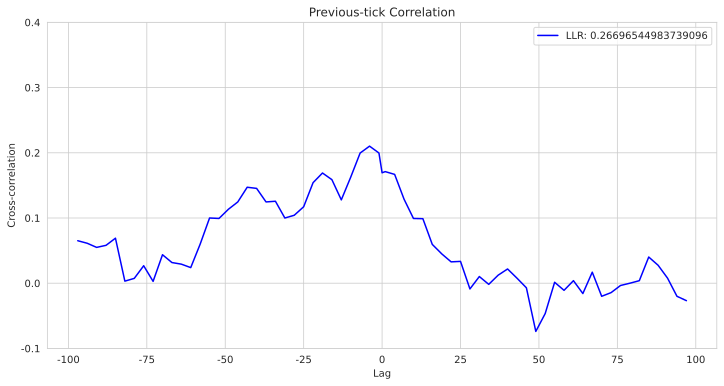

In [22]:
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(12,6))
plt.plot(index, res, color='b', label='LLR: %s'%ratio)
ax.set_ylim(-0.1, 0.4)
ax.set_title('HY Correlation')
ax.set_xlabel('Lag')
ax.set_ylabel('Cross-correlation')
plt.legend(loc=0)

In [57]:
res[res.__len__()//2]

0.16933090959099134

In [17]:
hy_corr(ci, ht, timedelta(seconds=0))

0.16933090959099134

In [9]:
def obtain_cross_correlation(code1, code2, date, grid):
    src = RemoteSrc()
    asset1 = src.get_raw_bars(code1, date)
    asset2 = src.get_raw_bars(code2, date)
    begin_time = '09:30:00'
    end_time = '14:57:00'

    # preprocessing
    range_1 = (asset1['time'] >= begin_time)&(asset1['time'] < end_time)
    asset1 = asset1[range_1]
    asset1['midquote'] = (asset1['ask_price1'] + asset1['bid_price1'])/2
    asset1['delta_quote'] = asset1['midquote'].diff()
    asset1 = asset1[asset1['delta_quote'] != 0][['delta_quote', 'server_time']]

    range_2 = (asset2['time'] >= begin_time)&(asset2['time'] < end_time)
    asset2 = asset2[range_2]
    asset2['midquote'] = (asset2['ask_price1'] + asset2['bid_price1'])/2
    asset2['delta_quote'] = asset2['midquote'].diff()
    asset2 = asset2[asset2['delta_quote'] != 0][['delta_quote', 'server_time']]

    res_lag = list(map(lambda lag: hy_corr(asset1, asset2, lag, choice='lag'), grid))
    res_lead = list(map(lambda lag: hy_corr(asset1, asset2, lag, choice='lead'), grid))
    res_total = res_lag[::-1] + [hy_corr(asset1, asset2, timedelta(seconds=0))] + res_lead
    return np.array(res_lag), np.array(res_lead), np.array(res_total)
    
def obtain_statistics(code_pair:tuple, date, grid):
    code1, code2 = code_pair
    res_lag, res_lead, res_total = obtain_cross_correlation(code1, code2, date, grid)
    max_lead_corr, max_lag_corr = res_lead.max(), res_lag.max()
    max_lead, max_lag = grid[res_lead.argmax()], grid[res_lag.argmax()]
    llr = (res_lead**2).sum()/(res_lag**2).sum()
    print("maximum lead correlation (lead = %s): %s"%(max_lead, max_lead_corr))
    print("maximum lag correlation (lag = %s): %s"%(max_lag, max_lag_corr))
    print("Lead/lag ratio of stock %s and %s: %s"%(code1, code2, llr))
    summary = {'max_lead': max_lead, 'max_lead_corr': max_lead_corr, 'max_lag': max_lag, 'max_lag_corr': max_lag_corr, 'hy_corr': res_total, 'LLR':llr}
    return summary
    # return max_lead, max_lead_corr, max_lag, max_lag_corr, llr, res_total

In [13]:
# nums = [i/100 for i in list(range(1,10))] + [i/10 for i in list(range(1,10))] + list(range(1,11)) + [15, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 180, 240, 300]
nums = [i/2 for i in list(range(1,21))] + [15, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 180, 240, 300]
grid = [timedelta(seconds=i) for i in nums]
nums.__len__()

35

In [14]:
list(product(*[[1], [3,4,5]]))

[(1, 3), (1, 4), (1, 5)]

In [15]:
from multiprocessing import cpu_count
import functools
import dask
def scan_all_pairs(code_pairs, date, grid):
    f_par = functools.partial(obtain_statistics, date=date, grid=grid)
    result = joblib.Parallel(n_jobs=max(cpu_count() - 1, 1))(joblib.delayed(f_par)(code_pair) for code_pair in code_pairs)
    # with dask.config.set(scheduler='processes', num_workers=cpu_count()-1):
        # result = dask.compute(dask.delayed(f_par)(code_pair) for code_pair in code_pairs)
    return result

In [16]:
%%time
from itertools import product

code_list1 = ['600030']
code_list2 = ['600837', '600838']
all_pairs = list(product(*[code_list1, code_list2]))

summary = scan_all_pairs(all_pairs, date, grid)
summary

maximum lead correlation (lead = 0:00:05): 0.19080530768880302
maximum lag correlation (lag = 0:00:02.500000): 0.23692245770215645
Lead/lag ratio of stock 600030 and 600837: 0.5417169082253731
maximum lead correlation (lead = 0:01:00): 0.09076645875699274
maximum lag correlation (lag = 0:00:20): 0.08142834571614853
Lead/lag ratio of stock 600030 and 600838: 0.9874177566908056
CPU times: user 466 ms, sys: 1.27 s, total: 1.74 s
Wall time: 1min 18s


[{'max_lead': datetime.timedelta(seconds=5),
  'max_lead_corr': 0.19080530768880302,
  'max_lag': datetime.timedelta(seconds=2, microseconds=500000),
  'max_lag_corr': 0.23692245770215645,
  'hy_corr': array([ 0.04858143,  0.03978044,  0.01302545,  0.08941799,  0.06899971,
          0.09716285,  0.05632629, -0.0017602 ,  0.04365287,  0.01584177,
          0.09645877,  0.14539224,  0.08308128,  0.14468816,  0.12462192,
          0.16264216,  0.17214722,  0.17144315,  0.1763717 ,  0.20242261,
          0.19925425,  0.19960629,  0.20031037,  0.19467774,  0.20066241,
          0.18658084,  0.20207057,  0.21016747,  0.2158001 ,  0.22812147,
          0.23692246,  0.22460108,  0.19749405,  0.19960629,  0.20171853,
          0.16933091,  0.1629942 ,  0.17109111,  0.18411656,  0.17073907,
          0.1746115 ,  0.17038703,  0.17390742,  0.16686663,  0.18482064,
          0.19080531,  0.18658084,  0.17214722,  0.15243302,  0.12884639,
          0.11124442,  0.1038516 ,  0.09927509,  0.08624963,

In [17]:
summary[0]

{'max_lead': datetime.timedelta(seconds=5),
 'max_lead_corr': 0.19080530768880302,
 'max_lag': datetime.timedelta(seconds=2, microseconds=500000),
 'max_lag_corr': 0.23692245770215645,
 'hy_corr': array([ 0.04858143,  0.03978044,  0.01302545,  0.08941799,  0.06899971,
         0.09716285,  0.05632629, -0.0017602 ,  0.04365287,  0.01584177,
         0.09645877,  0.14539224,  0.08308128,  0.14468816,  0.12462192,
         0.16264216,  0.17214722,  0.17144315,  0.1763717 ,  0.20242261,
         0.19925425,  0.19960629,  0.20031037,  0.19467774,  0.20066241,
         0.18658084,  0.20207057,  0.21016747,  0.2158001 ,  0.22812147,
         0.23692246,  0.22460108,  0.19749405,  0.19960629,  0.20171853,
         0.16933091,  0.1629942 ,  0.17109111,  0.18411656,  0.17073907,
         0.1746115 ,  0.17038703,  0.17390742,  0.16686663,  0.18482064,
         0.19080531,  0.18658084,  0.17214722,  0.15243302,  0.12884639,
         0.11124442,  0.1038516 ,  0.09927509,  0.08624963,  0.09751489,
 

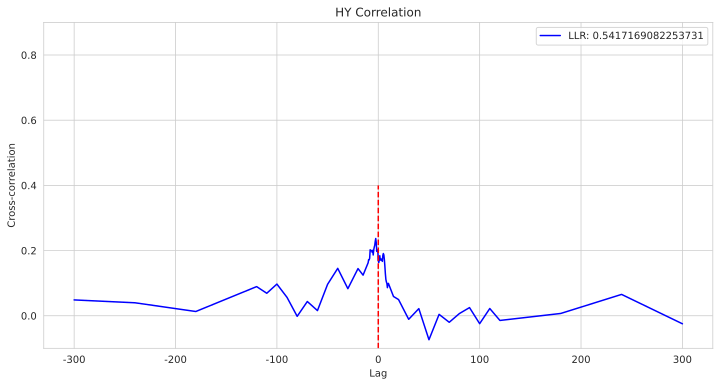

In [18]:
index = [-i for i in nums[::-1]] + [0] + nums
ratio = summary[0]['LLR']
res = summary[0]['hy_corr']
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(12,6))
plt.plot(index, res, color='b', label='LLR: %s'%ratio)
ax.set_ylim(-0.1, 0.9)
ax.set_title('HY Correlation')
ax.set_xlabel('Lag')
ax.set_ylabel('Cross-correlation')
plt.legend(loc=0)
plt.vlines(x = 0, ymin=-0.1, ymax=0.4, linestyles='dashed', color='r')

In [176]:
a, b, c, d, e = obtain_statistics(('600030', '600837'), '20211230', grid)

maximum lead correlation (lead = 0:00:05): 0.19080530768880302
maximum lag correlation (lag = 0:00:02.500000): 0.23692245770215645
Lead/lag ratio of stock 600030 and 600837: 0.5417169082253731


In [118]:
np.round(e, 3)

array([ 0.049,  0.04 ,  0.013,  0.089,  0.069,  0.097,  0.056, -0.002,
        0.044,  0.016,  0.096,  0.145,  0.083,  0.145,  0.125,  0.163,
        0.172,  0.171,  0.176,  0.202,  0.199,  0.2  ,  0.2  ,  0.195,
        0.201,  0.187,  0.202,  0.21 ,  0.216,  0.228,  0.237,  0.225,
        0.197,  0.2  ,  0.202,  0.169,  0.163,  0.171,  0.184,  0.171,
        0.175,  0.17 ,  0.174,  0.167,  0.185,  0.191,  0.187,  0.172,
        0.152,  0.129,  0.111,  0.104,  0.099,  0.086,  0.098,  0.099,
        0.059,  0.05 , -0.011,  0.022, -0.074,  0.004, -0.02 ,  0.007,
        0.025, -0.024,  0.022, -0.014,  0.007,  0.065, -0.025])

In [136]:
a1, b1, c1, d1, e1 = obtain_statistics(('600644', '600837'), '20211230', grid)

maximum lead correlation (lead = 0:02:00): 0.0366848021977346
maximum lag correlation (lag = 0:05:00): 0.03557314152508025
Lead/lag ratio of stock 600644 and 600837: 0.9640793645956747


In [166]:
obtain_statistics(('600031', '600837'), '20211230', grid)

maximum lead correlation (lead = 0:00:07.500000): 0.12571803395831002
maximum lag correlation (lag = 0:00:30): 0.14367775309523234
Lead/lag ratio of stock 600031 and 600837: 0.7865180190478888


(datetime.timedelta(seconds=7, microseconds=500000),
 0.12571803395831002,
 datetime.timedelta(seconds=30),
 0.14367775309523234,
 array([ 1.10751601e-01,  1.97556911e-02, -9.57851687e-03,  5.50764720e-02,
         4.60966125e-02,  1.19731461e-03, -5.54561606e-15,  6.04643878e-02,
         1.10751601e-01,  1.08356972e-01,  1.22126090e-01,  1.34099236e-01,
         1.43677753e-01,  1.42480438e-01,  1.11948916e-01,  9.75811406e-02,
         9.39891968e-02,  1.04166371e-01,  9.63838260e-02,  1.08356972e-01,
         1.05363686e-01,  1.11948916e-01,  1.02969056e-01,  8.44106799e-02,
         8.62066519e-02,  7.90227642e-02,  6.40563316e-02,  6.16617024e-02,
         5.92670732e-02,  5.86684158e-02,  6.40563316e-02,  6.94442473e-02,
         5.92670732e-02,  4.84912417e-02,  5.20831855e-02,  5.08858709e-02,
         4.43006405e-02,  3.05315225e-02,  4.25046686e-02,  4.96885563e-02,
         5.20831855e-02,  4.66952698e-02,  5.38791574e-02,  6.10630451e-02,
         9.09959103e-02,  1.107516

In [132]:
np.round(e1, 3)

array([-0.031, -0.053,  0.051, -0.015,  0.013,  0.014,  0.033,  0.041,
        0.039,  0.122,  0.11 ,  0.068,  0.131,  0.157,  0.14 ,  0.13 ,
        0.138,  0.134,  0.152,  0.153,  0.164,  0.164,  0.173,  0.188,
        0.198,  0.196,  0.185,  0.183,  0.169,  0.159,  0.163,  0.169,
        0.155,  0.147,  0.146,  0.124,  0.133,  0.128,  0.157,  0.155,
        0.159,  0.149,  0.152,  0.14 ,  0.145,  0.138,  0.146,  0.153,
        0.133,  0.125,  0.105,  0.102,  0.1  ,  0.097,  0.097,  0.101,
        0.125,  0.131,  0.078,  0.06 ,  0.065,  0.04 ,  0.019,  0.022,
       -0.045, -0.069, -0.004, -0.033, -0.038, -0.02 ,  0.048])

In [95]:
hy_corr(ci, ht, timedelta(seconds=0))

0.16933090959099134

In [96]:
hy_corr(ci, ht, timedelta(seconds=0.1), choice='lead')

0.16299420195557215

In [103]:
hy_corr(ci, ht, timedelta(seconds=1.2), choice='lead')

0.1841165607403053

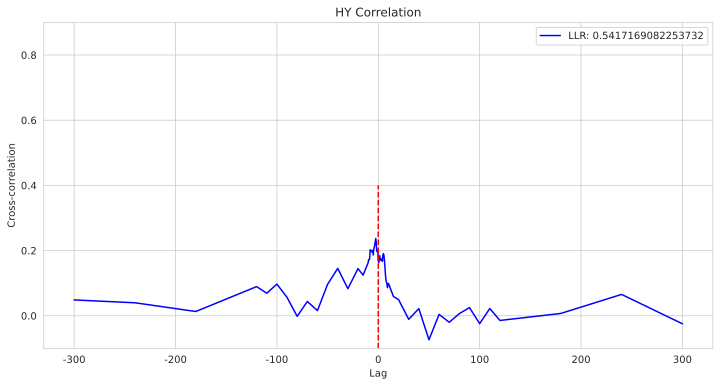

In [167]:
index = [-i for i in nums[::-1]] + [0] + nums
ratio = sum(e[e.__len__()//2+1:]**2)/sum(e[:e.__len__()//2]**2)
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(12,6))
plt.plot(index, e, color='b', label='LLR: %s'%ratio)
ax.set_ylim(-0.1, 0.9)
ax.set_title('HY Correlation')
ax.set_xlabel('Lag')
ax.set_ylabel('Cross-correlation')
plt.legend(loc=0)
plt.vlines(x = 0, ymin=-0.1, ymax=0.4, linestyles='dashed', color='r')

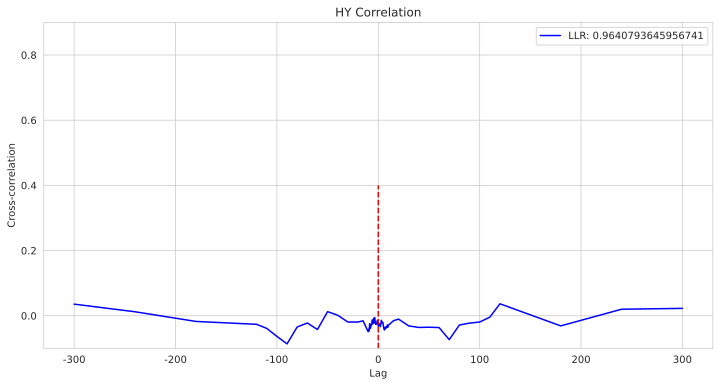

In [168]:
index = [-i for i in nums[::-1]] + [0] + nums
ratio = sum(e1[e1.__len__()//2+1:]**2)/sum(e1[:e1.__len__()//2]**2)
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(12,6))
plt.plot(index, e1, color='b', label='LLR: %s'%ratio)
ax.set_ylim(-0.1, 0.9)
ax.set_title('HY Correlation')
ax.set_xlabel('Lag')
ax.set_ylabel('Cross-correlation')
plt.legend(loc=0)
plt.vlines(x = 0, ymin=-0.1, ymax=0.4, linestyles='dashed', color='r')